In [3]:
import pandas as pd
import glob
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
total_time_seconds = 1 * 60 * 60
num_experiments = 1
calculate_features = False  # Set to False for faster prototyping, True for final runs
time_limit_seconds = total_time_seconds / num_experiments
autogluon_preset = "experimental_quality"

# Get list of all datasets
dataset_dir = "04_datasets/hpa_7c"
test_dataset_dir = "04_datasets/hpa_7b"
datasets = glob.glob(os.path.join(dataset_dir, "*.feather"))
print(f"Found {len(datasets)} datasets in {dataset_dir}")
print(datasets)

# 60min CPU run: TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home/anton/Documents/projects/framework/framework-predict/experiments/hpa_metrics/AutogluonModels/ag-20250328_093429")

Found 6 datasets in 04_datasets/hpa_7c
['04_datasets/hpa_7c/CPU.feather', '04_datasets/hpa_7c/Network.feather', '04_datasets/hpa_7c/Other.feather', '04_datasets/hpa_7c/Kepler.feather', '04_datasets/hpa_7c/Memory.feather', '04_datasets/hpa_7c/Disk_io.feather']


In [4]:
def train_and_test_across_datasets(train_file_path, test_file_path, time_limit, calculate_feature_importance=True):
    # Load the training dataset
    train_df = pd.read_feather(train_file_path)
    train_df = train_df.dropna()  # Drop NaN values

    # Load the testing dataset
    test_df = pd.read_feather(test_file_path)
    test_df = test_df.dropna()  # Drop NaN values

    # Check common columns
    common_cols = list(set(train_df.columns).intersection(set(test_df.columns)))
    print(f"Train dataset has {len(train_df.columns)} columns")
    print(f"Test dataset has {len(test_df.columns)} columns")
    print(f"Using {len(common_cols)} common columns for training and testing")
    # Filter both datasets to only include common columns
    train_df = train_df[common_cols]
    test_df = test_df[common_cols]

    train_name = os.path.basename(train_file_path)
    test_name = os.path.basename(test_file_path)

    print(f"Training on {train_name}, will test on {test_name}")

    if len(train_df.columns) > 1 and "target" in train_df.columns:
        label_column = "target"

        # Train predictor on training dataset
        print(f"Training model on {train_name}...")
        predictor = TabularPredictor(label=label_column, problem_type="regression").fit(train_df, time_limit=time_limit,
                                                                                        verbosity=2,
                                                                                        presets=autogluon_preset)

        # Get training performance
        train_performance = predictor.leaderboard(silent=True)['score_val'][0]

        # Calculate feature importance only if flag is enabled
        if calculate_feature_importance:
            print("Calculating feature importance...")
            feature_importances = predictor.feature_importance(train_df).head(5)
            top_features = feature_importances.index.tolist()
            feature_importance_values = feature_importances['importance'].values.tolist()
        else:
            print("Skipping feature importance calculation...")
            top_features = []
            feature_importance_values = []

        # Test on the test dataset
        if len(test_df.columns) > 1 and "target" in test_df.columns:
            print(f"Testing model on {test_name}...")

            # Make predictions on test data
            y_pred = predictor.predict(test_df.drop(columns=[label_column]))

            # Evaluate performance on test data (assuming regression task)
            from sklearn.metrics import mean_squared_error, r2_score
            y_true = test_df[label_column]

            test_mse = mean_squared_error(y_true, y_pred)
            test_r2 = r2_score(y_true, y_pred)

            result = {
                "train_dataset": train_name,
                "test_dataset": test_name,
                "train_performance": train_performance,
                "test_mse": test_mse,
                "test_r2": test_r2,
                "model_summary": predictor.fit_summary()
            }

            # Add feature importance info only if calculated
            if calculate_feature_importance:
                result["top_features"] = top_features
                result["feature_importance"] = feature_importance_values

            return result
        else:
            result = {
                "train_dataset": train_name,
                "test_dataset": test_name,
                "train_performance": train_performance,
                "error": "Test dataset does not have required columns or target variable"
            }

            # Add feature importance info only if calculated
            if calculate_feature_importance:
                result["top_features"] = top_features
                result["feature_importance"] = feature_importance_values

            return result
    else:
        return {
            "train_dataset": train_name,
            "test_dataset": test_name,
            "error": "Training dataset does not have required columns or target variable"
        }


# Initialize the results dictionary
results = {}

# Process all datasets - add the parameter to disable feature importance for faster prototyping


# Process all datasets
for i, dataset in enumerate(datasets):
    if i >= num_experiments:
        break
    results[dataset] = train_and_test_across_datasets(
        dataset,
        dataset.replace(dataset_dir, test_dataset_dir),
        time_limit_seconds,
        calculate_feature_importance=calculate_features
    )


No path specified. Models will be saved in: "AutogluonModels/ag-20250328_093429"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          16
Memory Avail:       12.18 GB / 31.02 GB (39.3%)
Disk Space Avail:   146.52 GB / 913.75 GB (16.0%)
Presets specified: ['experimental_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies

Train dataset has 54 columns
Test dataset has 54 columns
Using 54 common columns for training and testing
Training on CPU.feather, will test on CPU.feather
Training model on CPU.feather...


Leaderboard on holdout data (DyStack):
                       model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            LightGBM_BAG_L2      -2.504862  -2.380257  root_mean_squared_error       27.456791    1252.893022  2688.469710                 0.929071                9.741615          51.909282            2       True         23
1        WeightedEnsemble_L3      -2.537182  -2.363506  root_mean_squared_error       27.780103    1305.325745  2907.819821                 0.001837                0.000772           0.142609            3       True         31
2       ExtraTreesMSE_BAG_L2      -2.724191  -2.485926  root_mean_squared_error       26.683011    1260.994022  2760.161710                 0.155291               17.842615         123.601282            2       True         27
3      ExtraTrees_r42_BAG_L2      -2.740855  -2.48488

Skipping feature importance calculation...
Testing model on CPU.feather...
*** Summary of fit() ***
Estimated performance of each model:
                       model  score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -1.112133  root_mean_squared_error    3124.214835  5473.220628                0.000838           0.242615            3       True         45
1          LightGBMXT_BAG_L2  -1.140979  root_mean_squared_error    2687.736824  4458.880881              284.646481         164.272419            2       True         28
2            LightGBM_BAG_L2  -1.163376  root_mean_squared_error    2795.975032  4469.608367              392.884690         174.999905            2       True         29
3       ExtraTreesMSE_BAG_L2  -1.211442  root_mean_squared_error    2415.924289  4382.809135               12.833946          88.200673            2       True         31
4     Ex

/tmp/ipykernel_1449700/2990965739.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Train-Test Pair", y="Training Performance", palette="Blues_d")


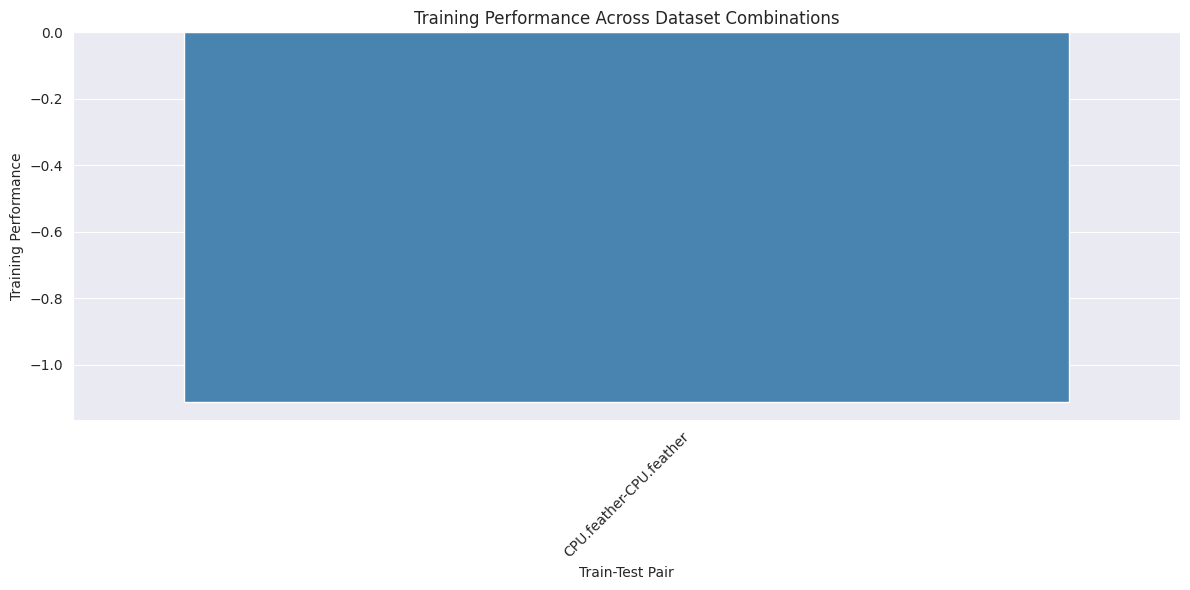

/tmp/ipykernel_1449700/2990965739.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Train-Test Pair", y="Testing R²", palette="Greens_d")


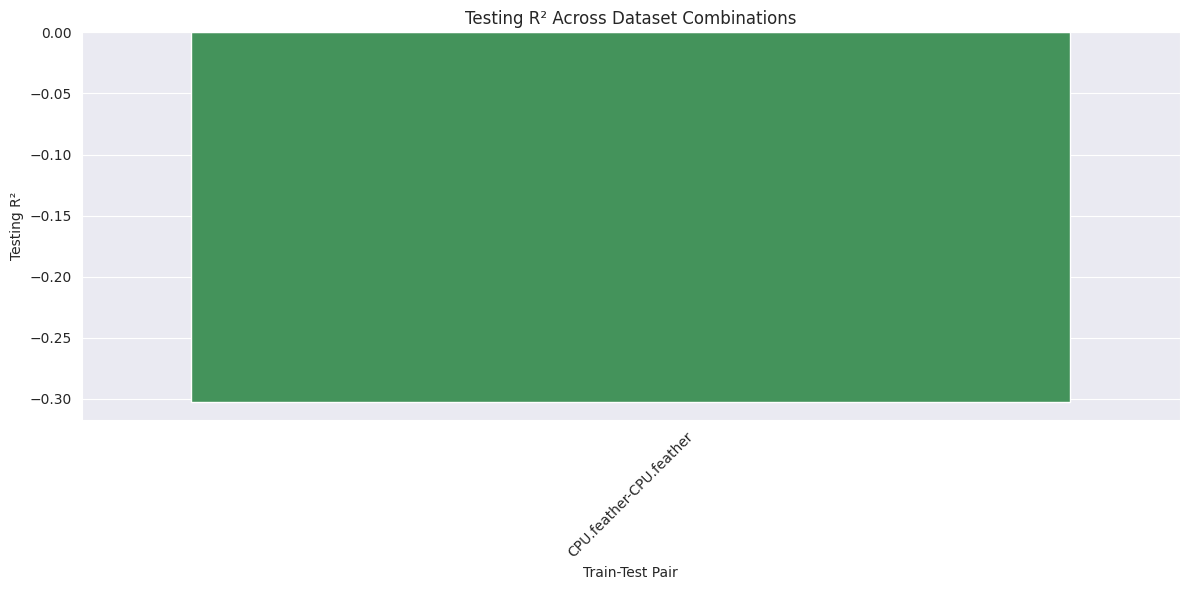

/tmp/ipykernel_1449700/2990965739.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Train-Test Pair", y="Testing MSE", palette="Reds_d")


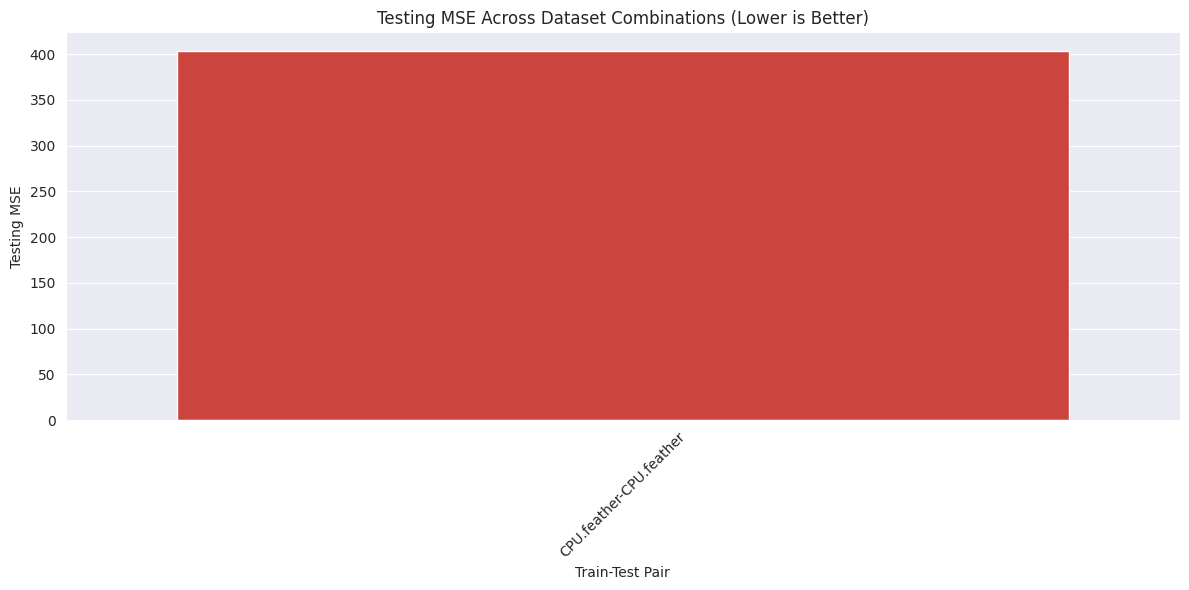

No valid feature importance data found in results.


In [5]:
# Create visualization of results
# 1. Performance comparison (now with both train and test performance)
summary_df = pd.DataFrame([
    {
        "Train-Test Pair": f"{res['train_dataset']}-{res['test_dataset']}",
        "Training Performance": res["train_performance"],
        "Testing R²": res.get("test_r2", None),
        "Testing MSE": res.get("test_mse", None)
    }
    for dataset, res in results.items()
    if "train_performance" in res and "error" not in res
])

# Plot training performance
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Train-Test Pair", y="Training Performance", palette="Blues_d")
plt.title("Training Performance Across Dataset Combinations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot testing performance (R²)
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Train-Test Pair", y="Testing R²", palette="Greens_d")
plt.title("Testing R² Across Dataset Combinations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot testing performance (MSE)
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Train-Test Pair", y="Testing MSE", palette="Reds_d")
plt.title("Testing MSE Across Dataset Combinations (Lower is Better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Feature importance plots
valid_results = [(dataset, res) for dataset, res in results.items() if "top_features" in res]
num_datasets = len(valid_results)

if num_datasets > 0:
    fig, axes = plt.subplots(num_datasets, 1, figsize=(12, 5 * num_datasets))

    # Handle case with only one result
    if num_datasets == 1:
        axes = [axes]

    for i, (dataset, res) in enumerate(valid_results):
        axes[i].bar(res["top_features"], res["feature_importance"])
        axes[i].set_title(f"Top Features: {res['train_dataset']} → {res['test_dataset']}")
        axes[i].set_xlabel("Feature")
        axes[i].set_ylabel("Importance")
        axes[i].tick_params(axis='x', rotation=45)
        print(f"Top features for {res['train_dataset']} → {res['test_dataset']}: {res['top_features']}")

    plt.tight_layout()
    plt.show()
else:
    print("No valid feature importance data found in results.")

# 3. Add a correlation heatmap for training vs testing metrics
if len(summary_df) > 1:
    plt.figure(figsize=(10, 8))
    corr_metrics = summary_df[["Training Performance", "Testing R²", "Testing MSE"]].corr()
    sns.heatmap(corr_metrics, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Between Training and Testing Metrics")
    plt.tight_layout()
    plt.show()

# 4. Display errors if any
errors = [(dataset, res["error"]) for dataset, res in results.items() if "error" in res]
if errors:
    print("\nErrors encountered:")
    for dataset, error in errors:
        print(f"{os.path.basename(dataset)}: {error}")


In [10]:
# Create visualization of results
# 1. Performance comparison
summary_df = pd.DataFrame([
    {"Dataset": res["dataset"], "Performance": res["performance"]}
    for res in results.values()
    if "performance" in res
])

plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Dataset", y="Performance", palette="viridis")
plt.title("Model Performance Across Datasets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Feature importance plots
valid_results = [r for r in results.values() if "top_features" in r]
num_datasets = len(valid_results)
fig, axes = plt.subplots(num_datasets, 1, figsize=(10, 5 * num_datasets))

for i, res in enumerate(valid_results):
    axes[i].bar(res["top_features"], res["feature_importance"])
    axes[i].bar(res["top_features"], res["feature_importance"])
    axes[i].set_title(f"Top Features: {res['dataset']}")
    axes[i].set_xlabel("Feature")
    axes[i].set_ylabel("Importance")
    axes[i].tick_params(axis='x', rotation=45)
    print(res["top_features"])

plt.tight_layout()
plt.show()

ValueError: Could not interpret value `Dataset` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>